In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as pl
import cufflinks as cf
from plotly.graph_objs import *

import hervpd as hp

pl.init_notebook_mode(connected=True)
cf.go_offline()
cf.set_config_file(offline=True, theme='pearl')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Naming variables to reuse them later

In [2]:
# DATA_PATH = '/home/ju/GDrive/Projects/HeRV/Data/PreProcessed/'
DATA_PATH = "C:\\Users\\ju\\GDrive\\Projects\\HeRV\\Data\\PreProcessed\\" 
filename = DATA_PATH + 'df_90_300.xlsx'
features_fd = ['hf', 'lf', 'lf_hf', 'vlf']
features_td = ['mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
features_all = features_td.copy()
features_all.extend(features_fd)
one_hot_labels = ['moving', 'slpeeping', 'focused', 'active']

['hf', 'lf', 'lf_hf', 'vlf']
['mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
['mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn', 'hf', 'lf', 'lf_hf', 'vlf']


## Aggregation (move to pipelnie)

In [6]:
df = pd.read_excel(filename)

movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.add_partition(df, movelist, pname='moving', labelIn=1, labelOut=0)
    
sleeplist = ['sleep']
df = hp.add_partition(df, sleeplist, pname='sleeping', labelIn=1, labelOut=0)

activelist = ['rest-active', 'focused-active', 'leisure-active', 'eat']
df = hp.add_partition(df, activelist, pname='active', labelIn=1, labelOut=0)

passivelist = ['rest-passive', 'leisure-passive', 'focused-passive', 'focused-passive ']
df = hp.add_partition(df, passivelist, pname='passive', labelIn=1, labelOut=0)

df['focused'] = np.where(df['activity'].isin(['focused-passive', 'focused-passive ','focused-active']), 1, 0)
df['relaxed'] = np.where(df['activity'].isin(['rest-active', 'rest-passive', 'leisure-passive', 'leisure-active']), 1, 0)

df['lyingdown'] = np.where(df['posture'].isin(['lie', 'lying down']), 1, 0)
df['sitting'] = np.where(df['posture'].isin(['sit','sitting']), 1, 0)
df['standing'] = np.where(df['posture'].isin(['stand','standing', 'standing ']), 1, 0)


df.head()

activity           hf       hfnu           lf     lf_hf       lfnu  \
0  focused-active  1516.951144  60.039661  1009.630650  0.665566  39.960339   
1  focused-active   443.401880  47.028536   499.433927  1.126369  52.971464   
2  focused-active   556.500976  47.711706   609.881487  1.095922  52.288294   
3  focused-active  2556.565157  60.438465  1673.464748  0.654575  39.561535   
4  focused-active   764.052485  41.364174  1083.083368  1.417551  58.635826   

         mhr        mrri  nn50  order    ...             vlf moving  sleeping  \
0  77.562161  786.159383   106      0    ...     2095.480124      0         0   
1  76.262208  791.421189    60      1    ...     1179.752702      0         0   
2  75.781084  795.275325    50      2    ...      651.724754      0         0   
3  73.561917  828.932249   136      3    ...     2548.982823      0         0   
4  76.085082  794.917313    93      4    ...     1214.872951      0         0   

   active  passive focused relaxed  lyingdown  sitting  standing  
0       1        0       1       0          0        1         0  
1       1        0       1       0          0        1         0  
2       1        0       1       0          0        1         0  
3       1        0       1       0          0        1         0  
4       1        0       1       0          0        1         0  

[5 rows x 29 columns]

## Plotting with pandas feault

C:\Users\Ju\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



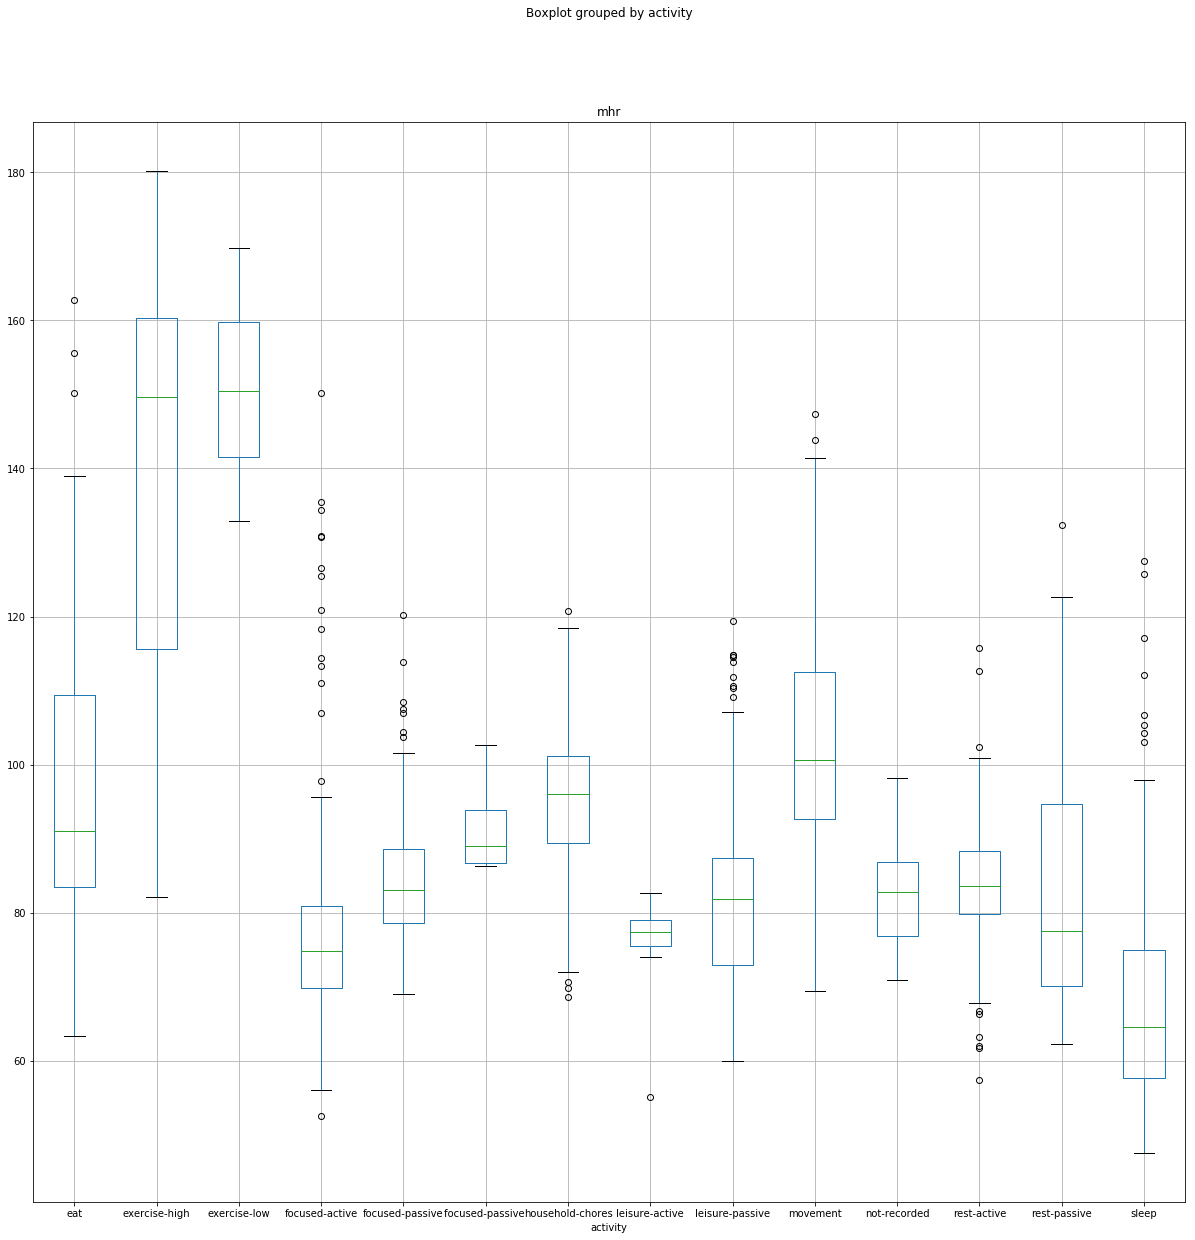

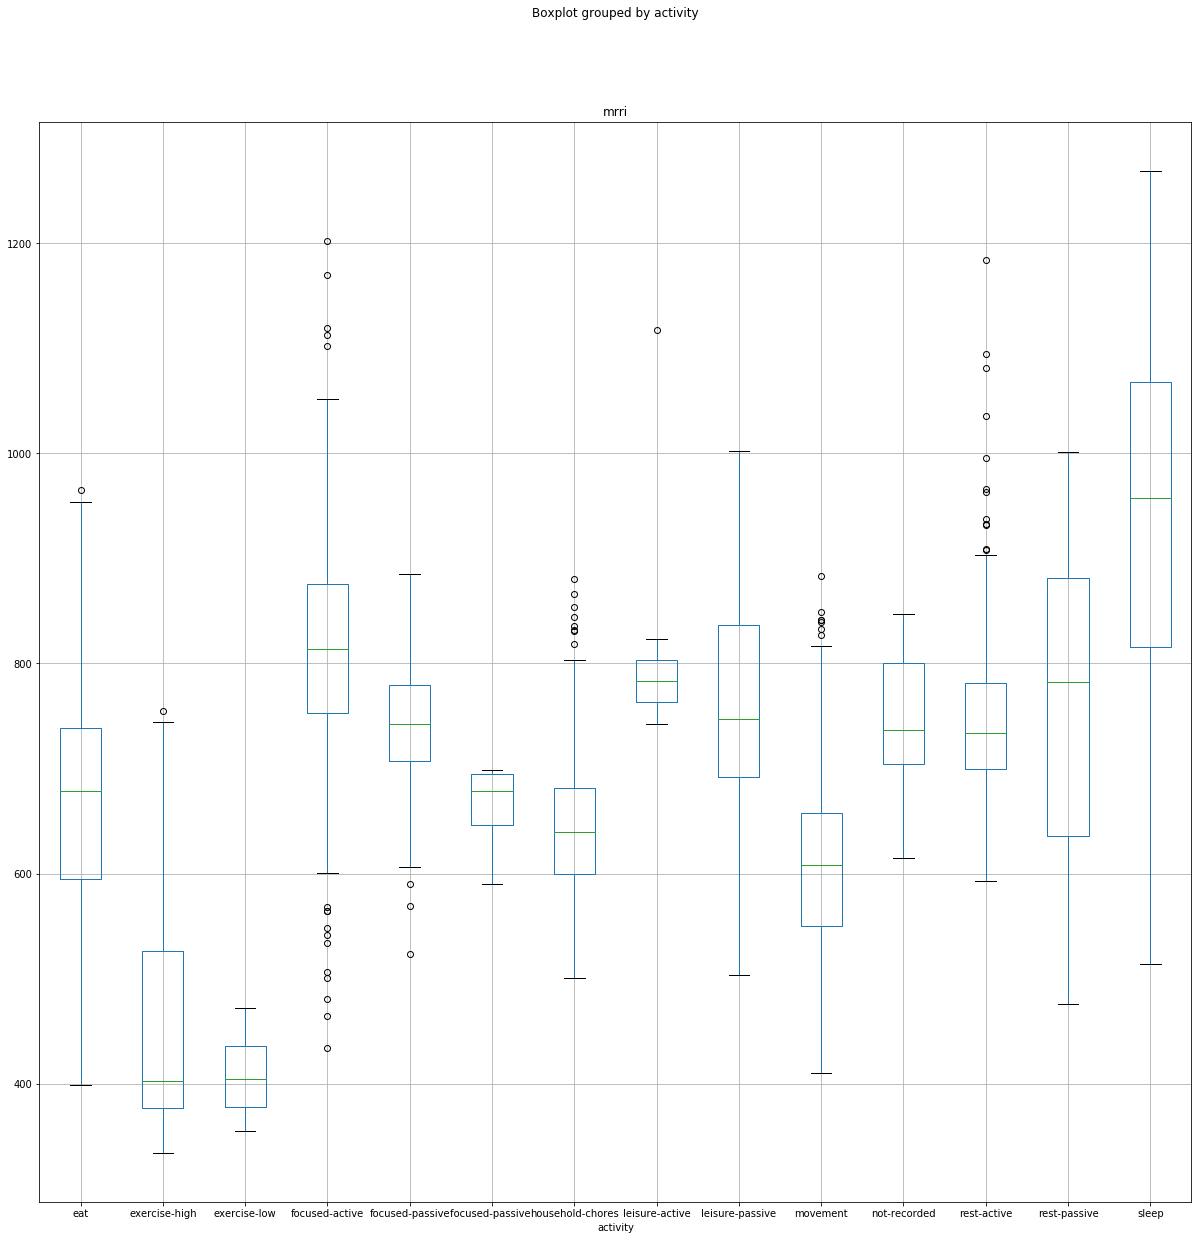

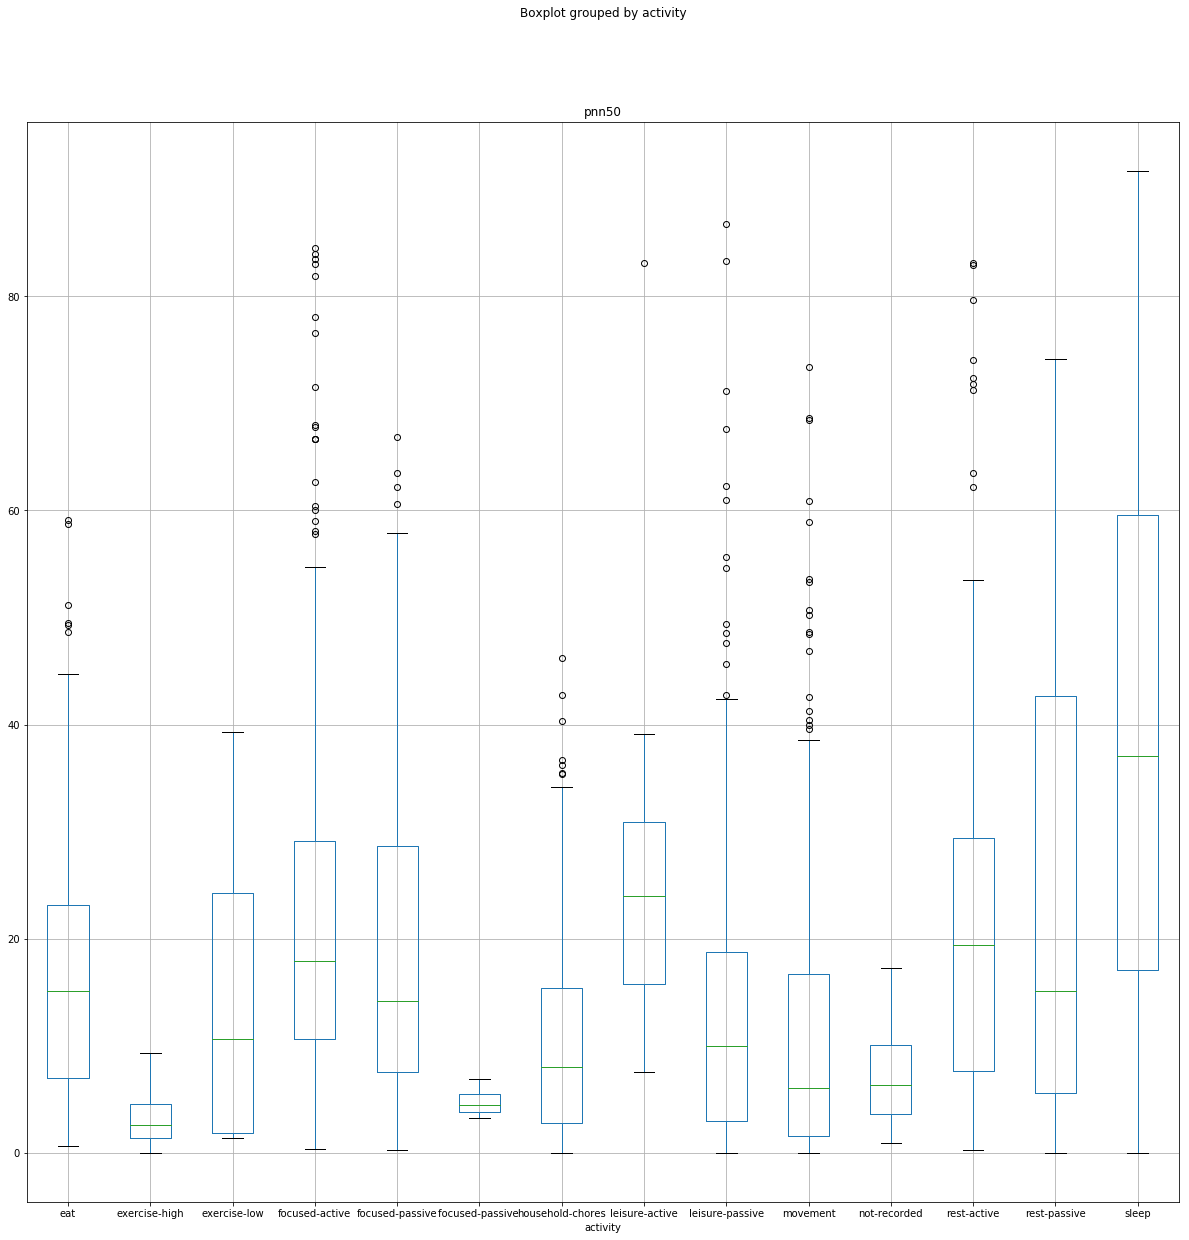

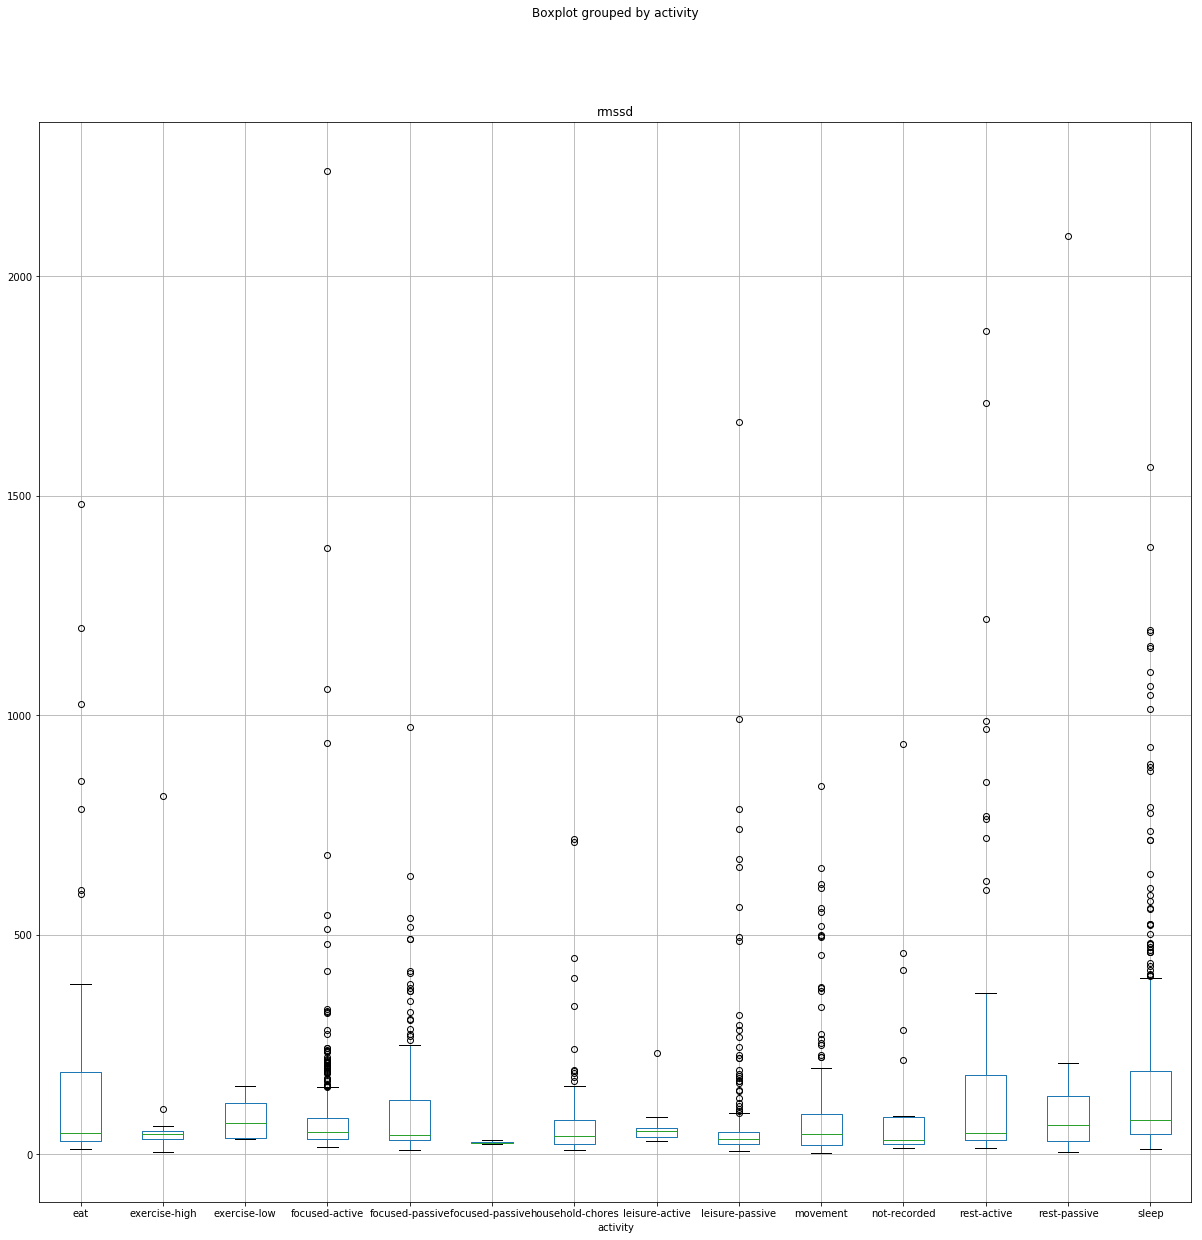

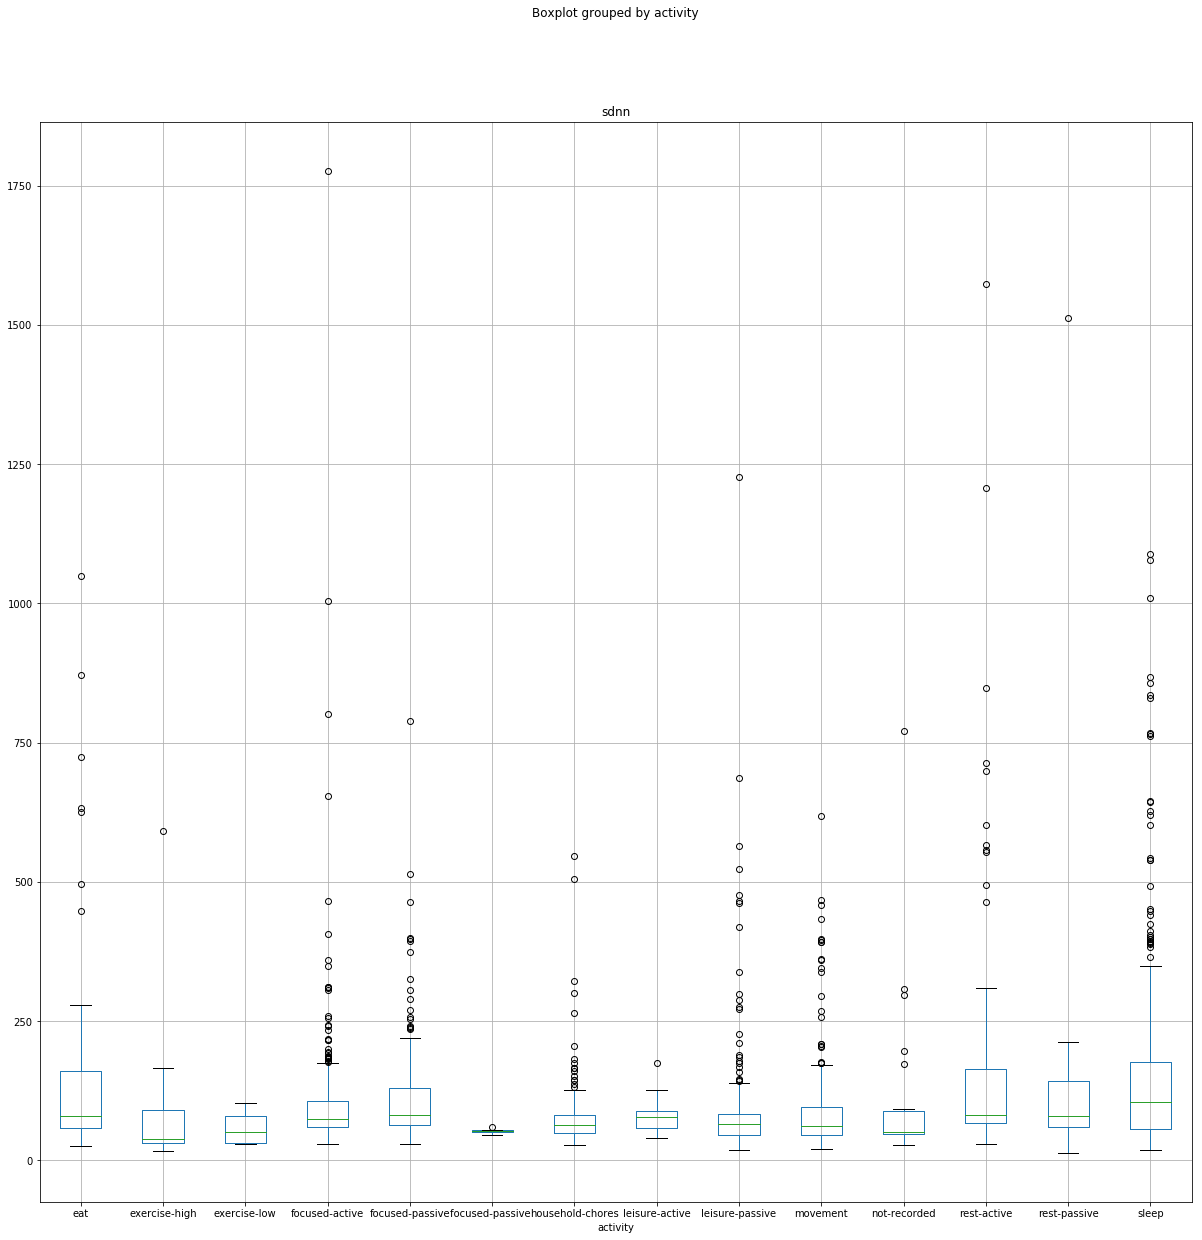

In [7]:
for feature in features_td:
    fig, ax = plt.subplots(figsize=(20,  20))
    df.boxplot(feature, 'activity', ax)

C:\Users\Ju\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



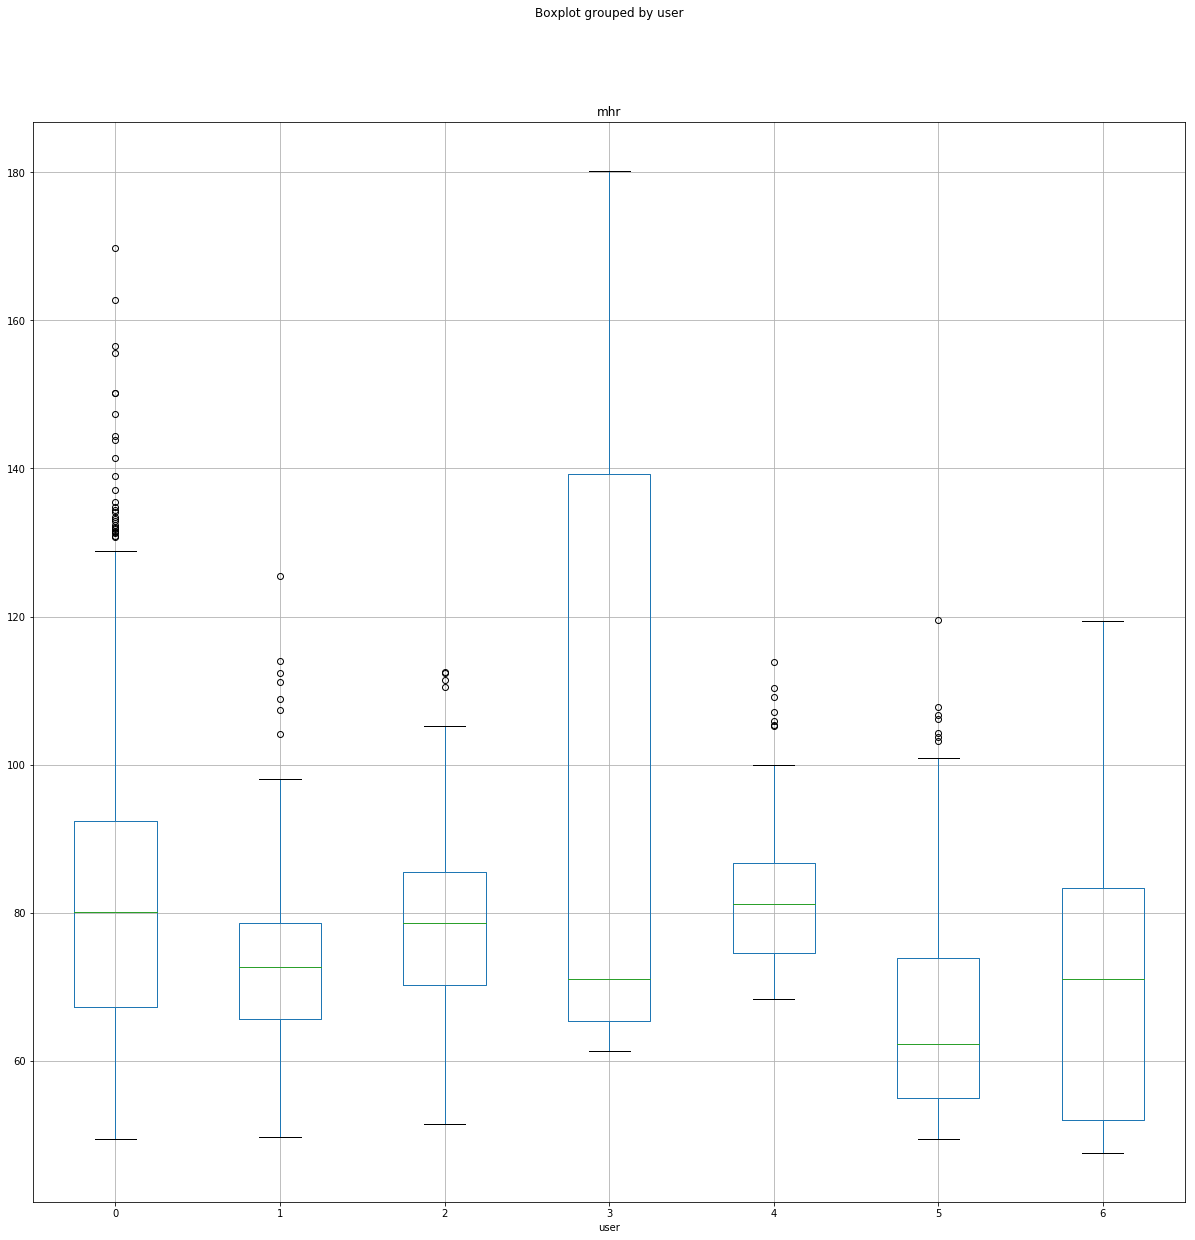

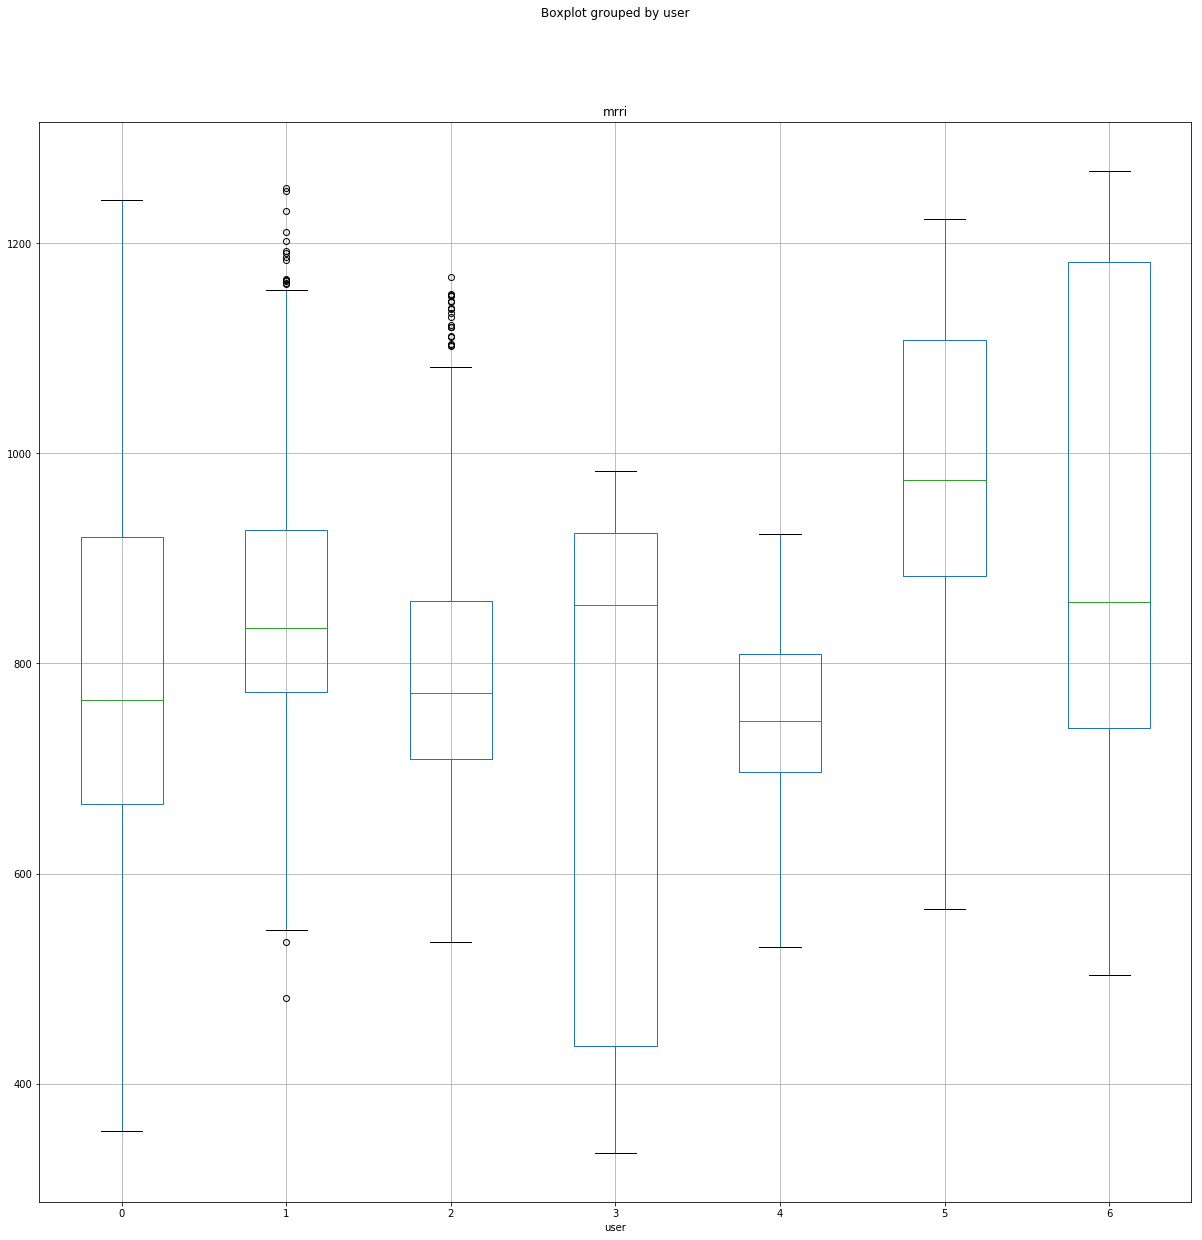

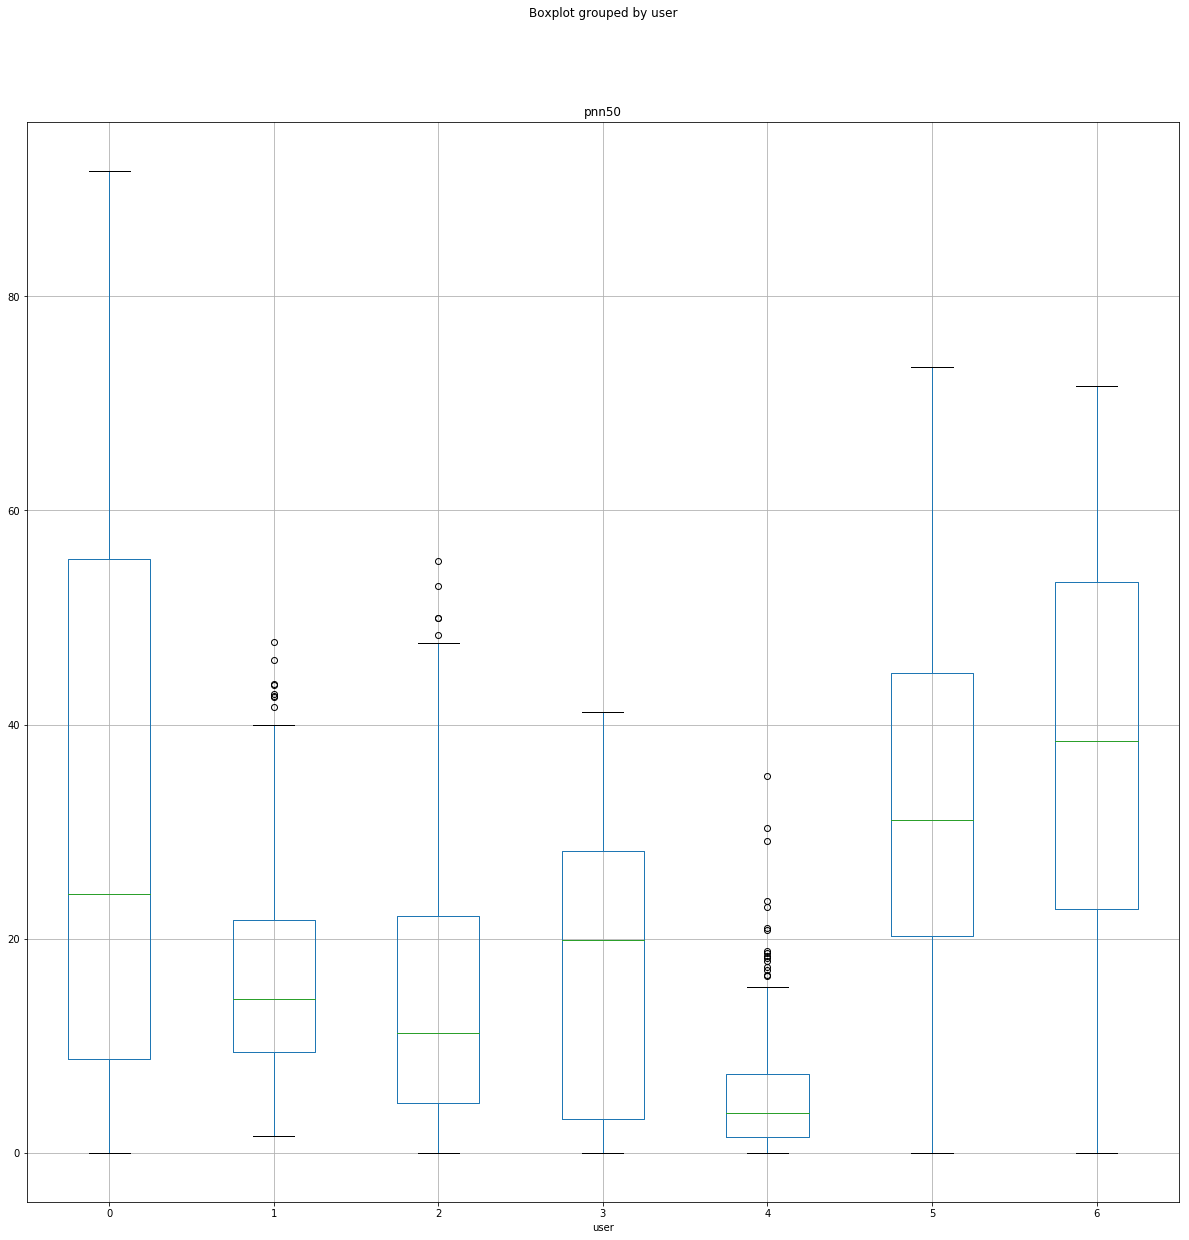

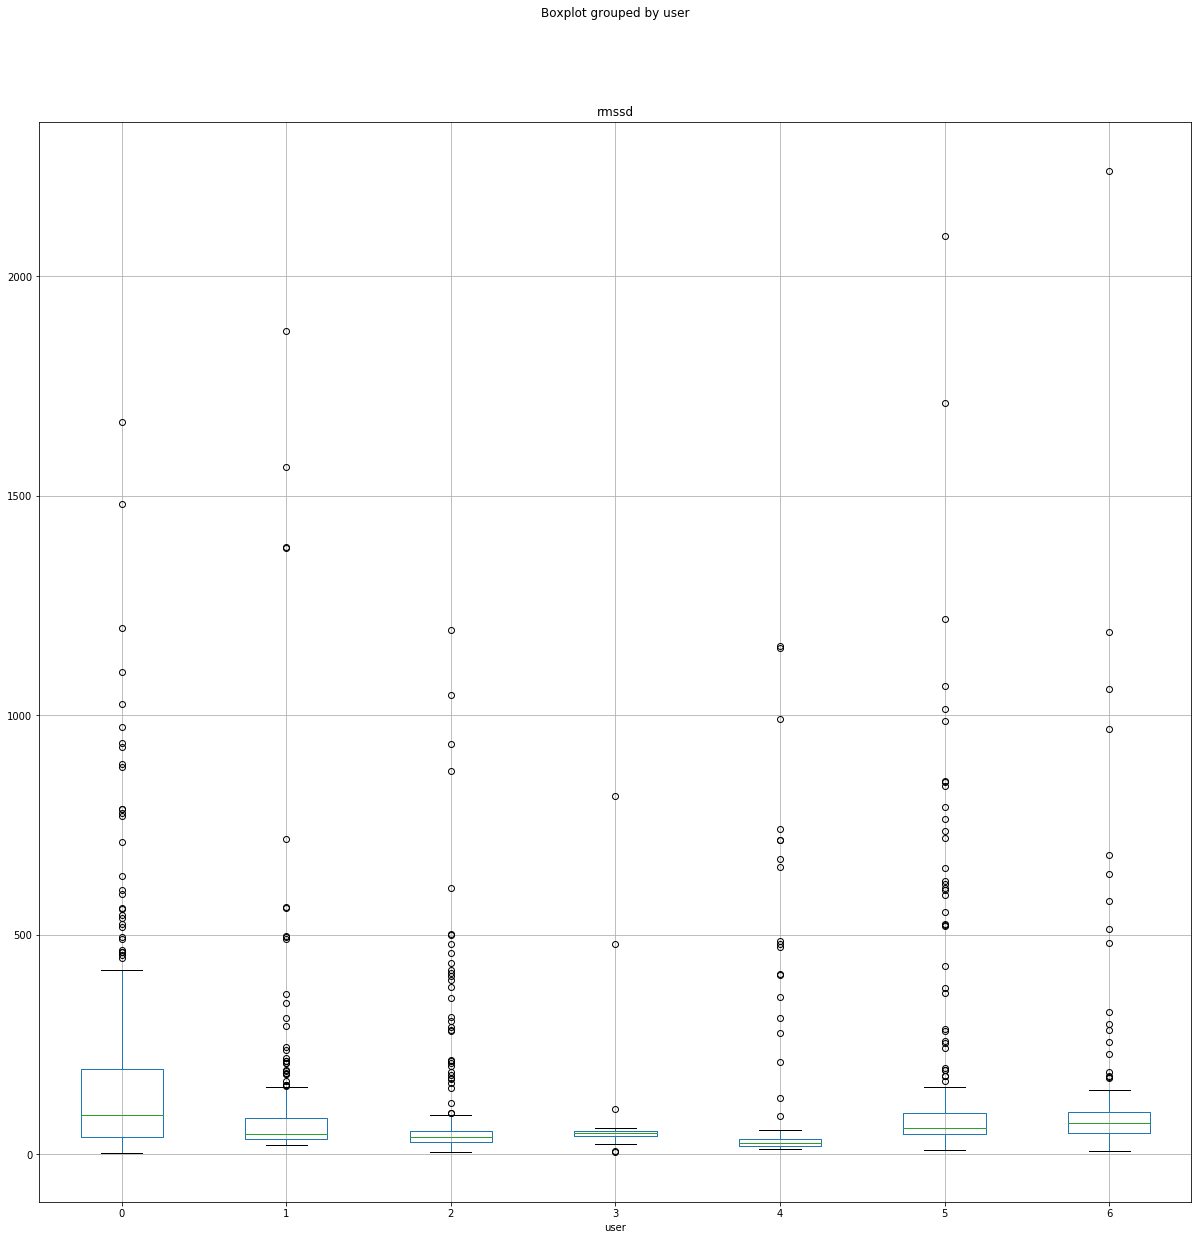

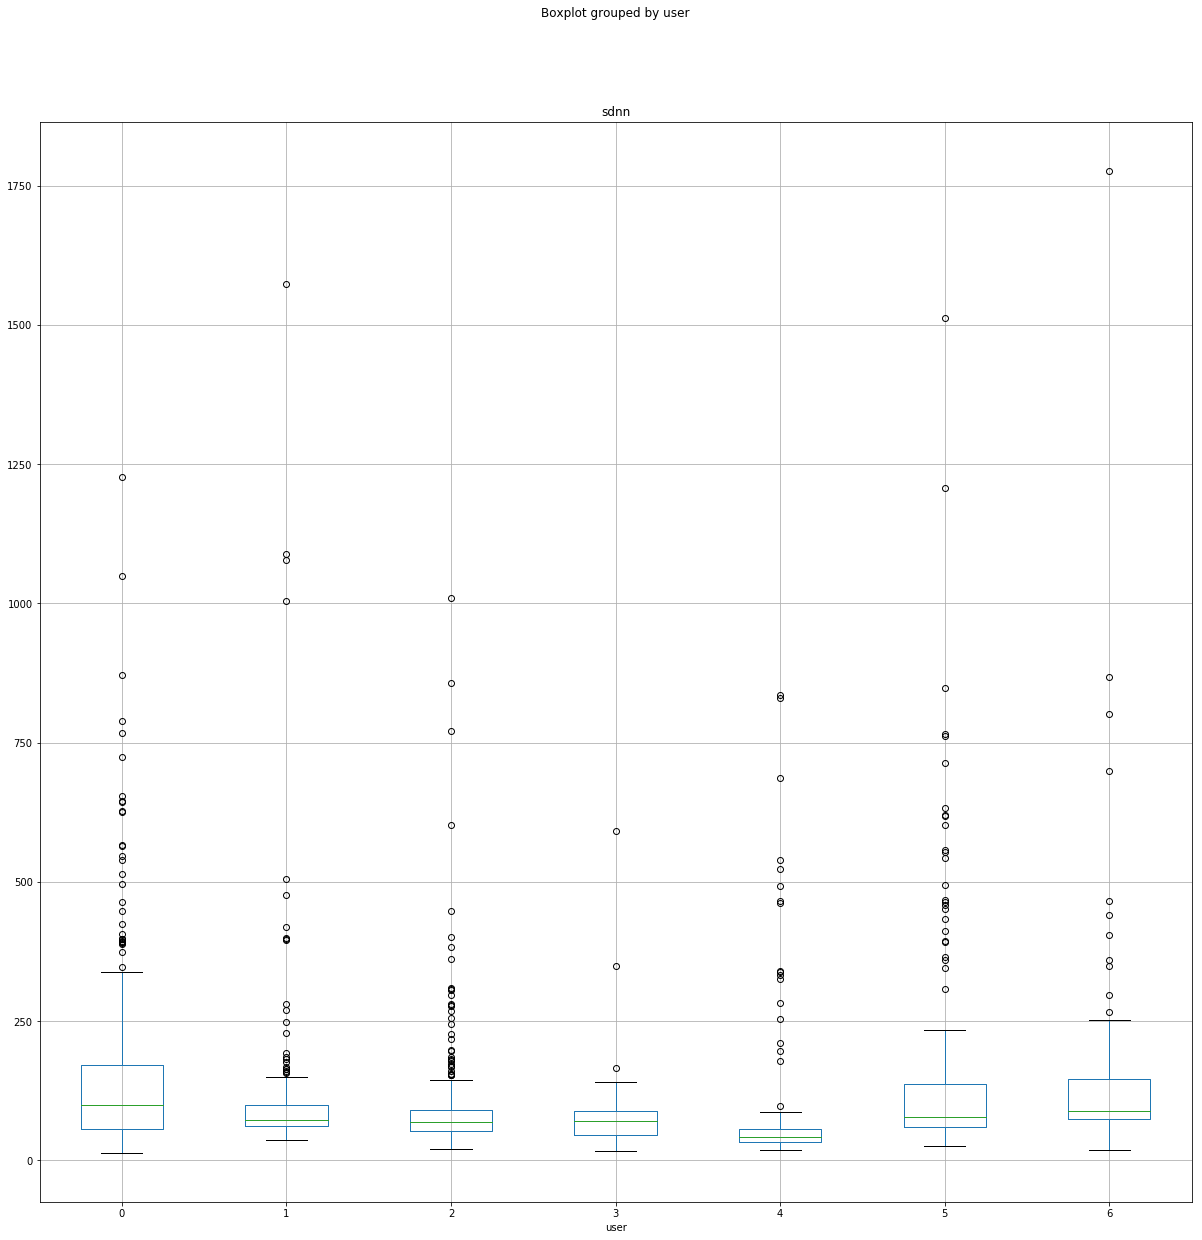

In [8]:
for feature in features_td:
    fig, ax = plt.subplots(figsize=(20,  20))
    df.boxplot(feature, 'user', ax)

## Plotting with plotly

In [9]:
# just a reminder for selection of rows and columns simultaneously
# df.loc[df.user==0,['mrri', 'mhr']]

def boxplot_compare(df, feature, groupby):
    
    data = []

    for val in df[groupby].unique():
        data.append(Box(y=df.loc[df[groupby]==val, feature], name=val, showlegend=False))
        
    layout = Layout(yaxis=dict(title=feature, zeroline=False))
    fig = Figure(data=data, layout=layout)
    pl.iplot(fig)   

### Viewing features per user

In [10]:
for feat in features_td:
    boxplot_compare(df, feat, 'user') 

In [12]:
for feat in features_fd:
    boxplot_compare(df, feat, 'user') 

### OMG! Those ouliers are ruining it! Let us prune some of it

In [13]:
print(df.activity.count())

val_hf = df['hf'] < 100000
val_lf = df['lf'] < 200000
val_vlf = df['vlf'] < 100000


df2 = df[val_hf & val_lf & val_vlf]

print(df2.activity.count())

2694
2564


In [14]:
for feat in features_fd:
    boxplot_compare(df2, feat, 'user')

In [15]:
for feat in features_td:
    boxplot_compare(df2, feat, 'user') 

### Now, on to the activities

In [17]:
for feat in features_td:
    boxplot_compare(df2, feat, 'activity') 

In [18]:
for label in ['moving', 'sleeping', 'focused', 'active']:
    for feat in features_td:
        boxplot_compare(df, feat, label) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [21]:
data = []

for feat in features_td:
        data.append(Box(x=df['moving'], y=df[feat], showlegend=False))

layout = Layout(yaxis=dict(title='features', zeroline=False), boxmode='group')

fig = Figure(data=data, layout=layout)
pl.iplot(fig)